## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [2]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [3]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root'

In [4]:
branches = [
            'B0_FitPVConst_tau_flat',
            'B0_TAUERR',
            'B0_TRUETAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber',
            'idxPV',
            'BDTresponse_wrongPV'
            ]

In [5]:
l0_cut =  '((abs(1115.683-varLambda0MassHypo_ppluspiminus)>17)|piplus_ProbNNp<0.4)&((abs(1115.683-varLambda0MassHypo_pminuspiplus)>17)|(piminus_ProbNNp<0.4))'

In [6]:
tree_mc = 'Bd2JpsiKS'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches,where=l0_cut, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [7]:
signal_dataframe_wrongPV['Delta_TAU'] = signal_dataframe_wrongPV['B0_FitPVConst_tau_flat'] -signal_dataframe_wrongPV['B0_TRUETAU']

In [8]:
signal_dataframe_wrongPV.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key='Bd2JpsiKS')

### Function to calculate the FOMs

### Configure  and define cuts 

In [9]:
perform_dilution_scan=False

In [10]:
lowerbound=5220 # rather arbitrary signal window definition
upperbound=5450
#B0_FitDaughtersConst_M.setRange('SIGREGION',lowerbound,upperbound)

subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    

cuts = np.linspace(0,70,40)  
cuttype = 'B0_FitPVConst_MinIPCHI2anyPV_flat'

cuts_for_which_to_store_sdata = []   

num_sig = []
num_bkg = []
num_all = []

cut_to_performance = {} 
cut_to_shape = {}

postfix = ''

### Calculate FOM

In [11]:
'''def calculate_foms(data_fit_cut,best_pv): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum_wrong    = 0
    cbkg_sum_wrong       = 0
    signal_sumw2_wrong   = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)
    
    timeres_power_bestPV = 0
    timeres_power_randomPV = 0
    

    
    tagomega = np.array(best_pv['B0_TAGOMEGA_OS'])
    tag1 = np.array(best_pv['B0_TAGDECISION_OS'])
    time = np.array(best_pv['B0_TAU']) 
    error = np.absolute(np.array(best_pv['Delta_TAU']))
    
    tagomega_wrong = np.array(data_fit_cut['B0_TAGOMEGA_OS'])
    tag1_wrong = np.array(data_fit_cut['B0_TAGDECISION_OS'])
    time_wrong = np.array(data_fit_cut['B0_TAU']) 
    error_wrong = np.absolute(np.array(data_fit_cut['Delta_TAU']))
    
    range_best_pv = best_pv.shape[0]-1
    
    for i in range(range_best_pv):
        signal_weight =  1 
        cbkg_weight   =  1 
        mistag        =  tagomega[i] 
        tag           =  tag1[i]
        decaytime     =  time[i]
        timeerror     =  error[i]
        
        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        cbkg_sum      += cbkg_weight

        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)

        timeres_power_bestPV    += timeerror_dilution*signal_weight
         
    print('+++++++++++++++++++++++++')
    print(cut)
    timeerror_dilution_theory = math.exp(-(delta_m*cut)**2)

    timeres_power_bestPV /= signal_sum
    #timeres_power_wrong /= signal_sum_wrong

    sig_yields_cut = data_fit_cut.shape[0] 
    efficiency = sig_yields_cut / sig_yields_init
    
    print("The efficiency of the cut is:")
    print(efficiency)
    
    fomname_to_value = {
        'TimeresPower_bestPV' : timeres_power_bestPV,
        'TimeresTheory': timeerror_dilution_theory,
        'Efficiency'   : efficiency
    }
    #return fomname_to_value

    for i in range(data_fit_cut.shape[0]):
        signal_weight_wrong =  1 
        cbkg_weight_wrong   =  1 
        mistag_wrong        =  tagomega_wrong[i] 
        tag_wrong           =  tag1_wrong[i]
        decaytime_wrong     =  time_wrong[i]
        timeerror_wrong     =  error_wrong[i]
        
        
        signal_sum_wrong    += signal_weight_wrong
        signal_sumw2_wrong  += signal_weight_wrong**2
        
        timeerror_dilution_wrong = math.exp(-(delta_m*timeerror_wrong)**2)
    
        timeres_power_randomPV     += timeerror_dilution_wrong *signal_weight_wrong 
        
    timeres_power_randomPV /= signal_sum_wrong  
    fomname_to_value.update({'TimeresPower_randomPV' : timeres_power_randomPV})
    
    return fomname_to_value'''

'def calculate_foms(data_fit_cut,best_pv): \n    import math\n    \n    signal_sum    = 0\n    cbkg_sum      = 0\n    signal_sumw2  = 0\n    signal_sum_wrong    = 0\n    cbkg_sum_wrong       = 0\n    signal_sumw2_wrong   = 0\n    \n    delta_m = 5065 \n    S = 0.691 #sin2beta value (average from HFAG)\n    \n    timeres_power_bestPV = 0\n    timeres_power_randomPV = 0\n    \n\n    \n    tagomega = np.array(best_pv[\'B0_TAGOMEGA_OS\'])\n    tag1 = np.array(best_pv[\'B0_TAGDECISION_OS\'])\n    time = np.array(best_pv[\'B0_TAU\']) \n    error = np.absolute(np.array(best_pv[\'Delta_TAU\']))\n    \n    tagomega_wrong = np.array(data_fit_cut[\'B0_TAGOMEGA_OS\'])\n    tag1_wrong = np.array(data_fit_cut[\'B0_TAGDECISION_OS\'])\n    time_wrong = np.array(data_fit_cut[\'B0_TAU\']) \n    error_wrong = np.absolute(np.array(data_fit_cut[\'Delta_TAU\']))\n    \n    range_best_pv = best_pv.shape[0]-1\n    \n    for i in range(range_best_pv):\n        signal_weight =  1 \n        cbkg_weight   =  1 \n

In [12]:
def calculate_foms(data_fit_cut,best_pv,yields_initial_bestpv,yields_initial_random): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum_wrong    = 0
    cbkg_sum_wrong       = 0
    signal_sumw2_wrong   = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)
    
    dilution_minipchi2_bestpv = 0
    dilution_minipchi2_random = 0
    dilution_minipchi2_random_test = 0
    dilution_minipchi2_bestpv_test = 0

    time = np.array(best_pv['B0_FitPVConst_tau_flat']) 
    error = np.absolute(np.array(best_pv['Delta_TAU']))
    
    time_wrong = np.array(data_fit_cut['B0_FitPVConst_tau_flat']) 
    error_wrong = np.absolute(np.array(data_fit_cut['Delta_TAU']))

    #calculate dilution and efficiency for best PV selection 
    efficiency_minipchi2_bestpv = best_pv.shape[0]  / yields_initial_bestpv
    
    for i in range(best_pv.shape[0]):
        signal_weight             =  1 
        timeerror                 =  error[i]        
        signal_sum                += signal_weight
        timeerror_dilution        = math.exp(-(delta_m*timeerror)**2)
        dilution_minipchi2_bestpv += timeerror_dilution
    
    dilution_minipchi2_bestpv     /= best_pv.shape[0]
    minipchi2_bestpv_poisson      = 1 / np.sqrt(best_pv.shape[0])
    dilution_minipchi2_bestpv_poisson_test = dilution_minipchi2_bestpv / minipchi2_bestpv_poisson
    
    
    
    #Calculate for random selection
    efficiency_minipchi2_random = data_fit_cut.shape[0]  / yields_initial_random
    for i in range(data_fit_cut.shape[0]):
        signal_weight_wrong       =  1 
        timeerror_wrong           =  error_wrong[i]
        signal_sum_wrong          += signal_weight_wrong
        timeerror_dilution_wrong  = math.exp(-(delta_m*timeerror_wrong)**2)
        dilution_minipchi2_random += timeerror_dilution_wrong *signal_weight_wrong 
        
    dilution_minipchi2_random /= data_fit_cut.shape[0]  
    minipchi2_random_poisson = 1 / np.sqrt(data_fit_cut.shape[0])
    
    dilution_minipchi2_random_poisson_test = dilution_minipchi2_random / minipchi2_random_poisson
    
    #Write to dictionary
    fomname_to_value = {
        'dilution_minipchi2_bestpv'   : dilution_minipchi2_bestpv,
        'efficiency_minipchi2_bestpv' : efficiency_minipchi2_bestpv,
        'minipchi2_bestpv_poisson'    : minipchi2_bestpv_poisson,
        'dilution_minipchi2_random'   : dilution_minipchi2_random,
        'efficiency_minipchi2_random' : efficiency_minipchi2_random,
        'minipchi2_random_poisson'    : minipchi2_random_poisson, 
        'dilution_minipchi2_random_poisson_test': dilution_minipchi2_random_test,
        'dilution_minipchi2_bestpv_poisson_test': dilution_minipchi2_bestpv_poisson_test,
    }
    
    return fomname_to_value


In [13]:

from ROOT import RooArgList
import subprocess, os
import time


initial_cut = str(cuts[0])
signal_dataframe_wrongPV.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
print('INFO: Call CandidateSelectionGrimReaper', flush=True)
my_env = os.environ.copy()
my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
             'lb-run DaVinci/v41r2 $BASH -c "' \
             'echo $PATH && ' \
             'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS "idxRunNumber""'                     
subprocess.Popen([my_command], env=my_env, shell=True)
print("Wait for GrimReaper")
time.sleep(100.0)    # pause 5.5 seconds
print("GrimReaper hopefully finished")
print('INFO: Read selected data', flush=True)
data_random = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc) 
data_bestpv = signal_dataframe_wrongPV.query('idxPV==0') 
yields_initial_bestpv = data_bestpv.shape[0]
yields_initial_random = data_random.shape[0]

INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data


In [14]:
yields_initial_random,yields_initial_random

(501573, 501573)

In [15]:
eff = signal_dataframe_wrongPV.query('BDTresponse_wrongPV>3.5').shape[0] / signal_dataframe_wrongPV.shape[0]
print(eff)

0.9610784472050927


In [16]:
from ROOT import RooArgList
import subprocess, os
import time

x=None



for cut in cuts:
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(cuttype,cut), flush=True)
    data_fit_cut = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)) 
    best_pv = signal_dataframe_wrongPV.query('idxPV==0').query('{0}>{1}'.format(cuttype,cut))
    data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key=tree_mc)
    print('INFO: Call CandidateSelectionGrimReaper', flush=True)
    
    my_env = os.environ.copy()
    my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
    my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
    my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
    my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
        'lb-run DaVinci/v41r2 $BASH -c "' \
        'echo $PATH && ' \
        'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root Bd2JpsiKS "idxRunNumber""'        
    subprocess.Popen([my_command], env=my_env, shell=True)
        
    print("Wait for GrimReaper")
    time.sleep(200.0)        # pause 5.5 seconds
    print("GrimReaper hopefully finished")
    print('INFO: Read selected data', flush=True)
    data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key=tree_mc)
    print('INFO: Start Calculation', flush=True)
    cut_to_shape[cut] = {} 
    cut_to_performance[cut] = {}
   
    
    foms = calculate_foms(data_fit_cut,best_pv,yields_initial_bestpv,yields_initial_random)
    cut_to_performance[cut].update(foms)
    
    print('INFO: Finish Calculation', flush=True)

INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>0.0
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>1.794871794871795
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>3.58974358974359
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>5.384615384615385
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
INFO: Finish Calculation
INFO: Starting to test cut B0_FitPVConst_Mi

In [17]:
import numpy as np

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


In [18]:
df_minipchi2 = pd.DataFrame()
df_minipchi2['dilution_minipchi2_bestpv'] = np.array(ys['dilution_minipchi2_bestpv'])
df_minipchi2['dilution_minipchi2_random'] = np.array(ys['dilution_minipchi2_random'])
df_minipchi2['efficiency_minipchi2_bestpv'] = np.array(ys['efficiency_minipchi2_bestpv'])
df_minipchi2['efficiency_minipchi2_random'] = np.array(ys['efficiency_minipchi2_random'])
df_minipchi2['minipchi2_random_poisson'] = np.array(ys['minipchi2_random_poisson'])
df_minipchi2['minipchi2_bestpv_poisson'] = np.array(ys['minipchi2_bestpv_poisson'])
df_minipchi2['dilution_minipchi2_random_poisson'] = df_minipchi2['dilution_minipchi2_random'] / df_minipchi2['minipchi2_random_poisson']
df_minipchi2['dilution_minipchi2_bestpv_poisson'] = df_minipchi2.dilution_minipchi2_bestpv / df_minipchi2.minipchi2_bestpv_poisson

In [19]:
df_minipchi2.to_csv('/home/chasenberg/plots/csv_data/minipchi2.csv')

In [20]:
df_minipchi2['dilution_minipchi2_bestpv'].max(),df_minipchi2['dilution_minipchi2_bestpv'].min()

(1.0, 0.99818411801422202)

In [21]:
df_minipchi2['efficiency_minipchi2_bestpv'].max(),df_minipchi2['efficiency_minipchi2_bestpv'].min()

(1.0, 0.95913011970643902)

### Compare Random PV vs. best PV selection

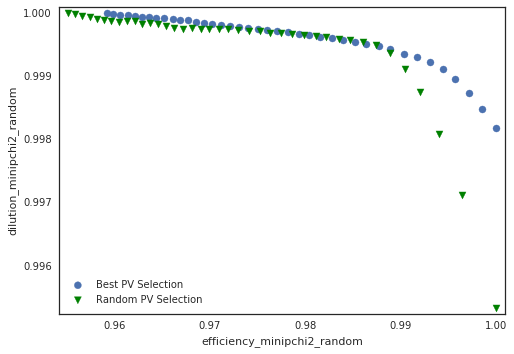

In [22]:
import seaborn as sns; sns.set_style('white')
plot_2 = sns.regplot(x='efficiency_minipchi2_bestpv', y='dilution_minipchi2_bestpv',marker='o',data=df_minipchi2,x_estimator=np.mean, fit_reg=False,label='Best PV Selection')
plot_1 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_random',marker='v',color='green',data=df_minipchi2,x_estimator=np.mean, fit_reg=False,label='Random PV Selection')
plot_1.legend(loc="lower left")
if df_minipchi2['dilution_minipchi2_bestpv'].min() < df_minipchi2['dilution_minipchi2_random'].min():
    plot_1.set(ylim=(df_minipchi2['dilution_minipchi2_bestpv'].min(), df_minipchi2['dilution_minipchi2_bestpv'].max()-0.001))
else:
    plot_1.set(ylim=(df_minipchi2['dilution_minipchi2_random'].min()-0.0001, df_minipchi2['dilution_minipchi2_random'].max()+0.0001))
plot_1.set(xlim=(df_minipchi2['efficiency_minipchi2_random'].min()-0.001, df_minipchi2['efficiency_minipchi2_random'].max()+0.001))
plt.savefig("/home/chasenberg/plots/wrong_pv/timeres_chi2_bestpv_vs_random.pdf")


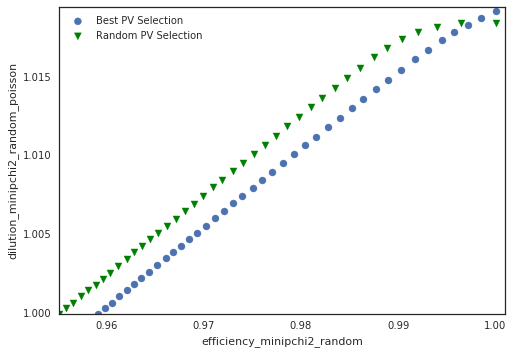

In [27]:
import seaborn as sns; sns.set_style('white')
df_minipchi2['factor_random'] = 1 / df_minipchi2.minipchi2_random_poisson
df_minipchi2['factor_bestpv'] = 1 / df_minipchi2.minipchi2_bestpv_poisson
plot_1 = sns.regplot(x='efficiency_minipchi2_bestpv', y='dilution_minipchi2_bestpv_poisson',data=df_minipchi2,x_estimator=np.mean,marker='o', fit_reg=False,label='Best PV Selection')
plot_2 = sns.regplot(x='efficiency_minipchi2_random', y='dilution_minipchi2_random_poisson',data=df_minipchi2,x_estimator=np.mean,marker='v',color='green', fit_reg=False,label='Random PV Selection')
plot_1.legend(loc="upper left")

if df_minipchi2['dilution_minipchi2_bestpv_poisson'].min() < df_minipchi2['dilution_minipchi2_random_poisson'].min():
    plot_1.set(ylim=(df_minipchi2['dilution_minipchi2_bestpv_poisson'].min(), df_minipchi2['dilution_minipchi2_bestpv_poisson'].max()+0.01))
else:
    plot_1.set(ylim=(df_minipchi2['dilution_minipchi2_random_poisson'].min(), df_minipchi2['dilution_minipchi2_random_poisson'].max()+0.001))
plot_1.set(xlim=(df_minipchi2['efficiency_minipchi2_random'].min(), df_minipchi2['efficiency_minipchi2_random'].max()+0.001))

plt.savefig("/home/chasenberg/plots/wrong_pv/timeres_chi2_bestpv_vs_random_poisson.pdf")

